<a href="https://colab.research.google.com/github/cl9612023/School-Learnig/blob/main/Test_For_Book/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
from keras.layers import Input,Dense,Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist
from keras.datasets import cifar10
import numpy as np
from scipy.stats import norm
import cv2

import matplotlib.pyplot as plt

In [ ]:
import keras
import sys
tf.compat.v1.disable_eager_execution()
print('keras : ',keras.__version__)
print('tensorflow : ',tf.__version__)
print('python : ',sys.version)

keras :  2.3.1
tensorflow :  1.15.2
python :  3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [ ]:
#超參數設定
batch_size = 1000
original_dim = 32*32 #圖片大小(一維)
intermediate_dim = 256 #中間層維度
latent_dim = 2 #潛在空間維度
np_epoch = 500 #跑幾次

#784>256>2圖片大小

In [ ]:
def sampling(args):
  z_mean,z_log_var = args
  epsilon = K.random_normal(shape = (batch_size,latent_dim),mean = 0.)#[1000,2]常態分布
  return z_mean + K.exp(z_log_var/2)*epsilon

In [ ]:
a=sampling([100,2])
print(a)

Tensor("add_3:0", shape=(1000, 2), dtype=float32)


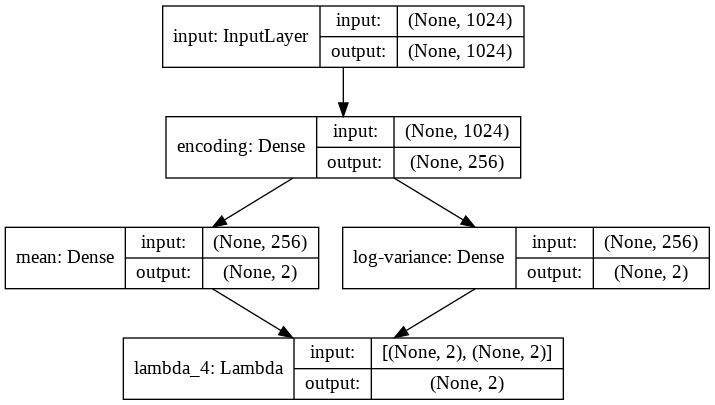

In [ ]:
#encoding
# Lambda(keras)將任意表達示封裝為Layer對象
x = Input(shape = (original_dim,),name = 'input')#輸入一維784
h = Dense(intermediate_dim,activation = 'relu',name = 'encoding')(x)#轉成256
z_mean = Dense(latent_dim , name = 'mean')(h)#其中一個轉成2
z_log_var = Dense(latent_dim , name = 'log-variance')(h)#其中一個轉成2
z = Lambda (sampling , output_shape = (latent_dim,))([z_mean,z_log_var])#輸入sample function(args)為list
encoder = Model(x, [z_mean,z_log_var,z],name = 'encoder')#一個輸入，三個輸出[z_mean,z_log_var,z]

#keras.ultils 會有版本問題(降版解決)
keras.utils.plot_model(encoder,show_shapes=True)

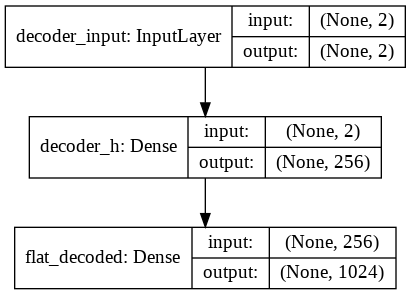

In [ ]:
input_decoder = Input(shape = (latent_dim,),name = "decoder_input")#輸入(2,)
decoder_h = Dense(intermediate_dim,activation = "relu",name = "decoder_h")(input_decoder)#轉成256
x_decoded = Dense(original_dim,activation = "sigmoid",name = "flat_decoded")(decoder_h)#轉成784
decoder = Model(input_decoder,x_decoded,name = "decoder")#一個輸入，一個輸出

keras.utils.plot_model(decoder,show_shapes=True)

In [ ]:
#x:輸入、output_combined:輸出
#encoder輸出3個，只輸入其中一個[2]
#x先經過encoder再經過decoder輸出output_combined
#encoder、decoder總類是模型(用keras中的Model把兩個模型連接)
#x是抓上面的輸入層
output_combined = decoder(encoder(x)[2])
vae = Model(x,output_combined)
vae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1024)              0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 263428    
_________________________________________________________________
decoder (Model)              (None, 1024)              263936    
Total params: 527,364
Trainable params: 527,364
Non-trainable params: 0
_________________________________________________________________


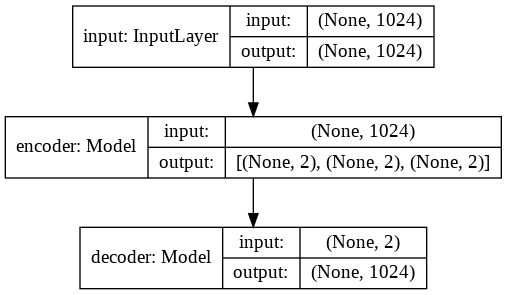

In [ ]:
keras.utils.plot_model(vae,show_shapes=True)

In [ ]:
def vae_loss(x,x_decoded_mean,z_log_var=z_log_var,z_mean=z_mean,original_dim=original_dim):
  xent_loss = original_dim * objectives.binary_crossentropy(x,x_decoded_mean)
  kl_loss = -0.5 * K.sum(1+z_log_var-K.square(z_mean)-K.exp(z_log_var),axis=-1)
  return xent_loss + kl_loss

vae.compile(optimizer='rmsprop',loss=vae_loss)

50000


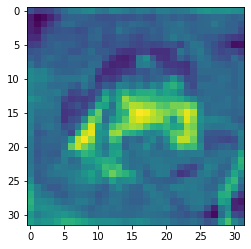

(50000, 32, 32)


In [ ]:
#(x_train,y_train),(x_test,y_tesy)=mnist.load_data()#載如圖片，這邊用不到label
(x_train,y_train),(x_test,y_tesy)=cifar10.load_data()
print(len(x_train))
new_x_train = np.zeros((len(x_train), 32, 32 ))
new_x_test = np.zeros((len(x_test), 32, 32 ))
for i in range(0,len(x_train)):
  new_x_train[i]=cv2.cvtColor(x_train[i], cv2.COLOR_BGR2GRAY)
for i in range(0,len(x_test)):
  new_x_test[i]=cv2.cvtColor(x_test[i], cv2.COLOR_BGR2GRAY)
plt.imshow(new_x_train[0])
plt.show()
print(new_x_train.shape)

In [ ]:
new_x_train=new_x_train.astype('float32')/255.#w圖片轉float，並將範圍改成[0-1]
new_x_test=new_x_test.astype('float32')/255.
print(new_x_train.shape)#總共60000，大小28*28，單通道
print(new_x_train.shape)#總共10000，大小28*28，單通道
print(new_x_train.shape[1:])#只取28，28，28
print(np.prod(new_x_train.shape[1:]))
print(len(new_x_train))

print("-------------------------------------")
print(np.prod([[1,2],[2,3]],axis=1))

(50000, 32, 32)
(50000, 32, 32)
(32, 32)
1024
50000
-------------------------------------
[2 6]


In [ ]:
new_x_train=new_x_train.reshape((len(new_x_train),np.prod(new_x_train.shape[1:])))#轉換shape(60000,784)
new_x_test=new_x_test.reshape((len(new_x_test),np.prod(new_x_test.shape[1:])))#轉換shape(10000,784)
print(new_x_train.shape)
print(new_x_test.shape)


(50000, 1024)
(10000, 1024)


In [ ]:
history_all = {}

history_all=vae.fit(new_x_train,new_x_train,
    shuffle=True,
    epochs=np_epoch,
    batch_size=batch_size,
    validation_data=(new_x_test,new_x_test),verbose=2)
#input-->latent_dim-->output(跟input比較):所以label輸入x和x(圖片和圖片)
#shuffle打亂資料
#epochs訓練次數
#batch_size分批送進神經網路的數量

Train on 50000 samples, validate on 10000 samples
Epoch 1/500
 - 1s - loss: 702.0353 - val_loss: 697.9038
Epoch 2/500
 - 1s - loss: 684.5734 - val_loss: 683.1751
Epoch 3/500
 - 1s - loss: 680.1608 - val_loss: 676.7667
Epoch 4/500
 - 1s - loss: 677.6431 - val_loss: 677.4456
Epoch 5/500
 - 1s - loss: 674.8237 - val_loss: 671.5900
Epoch 6/500
 - 1s - loss: 671.9478 - val_loss: 670.4911
Epoch 7/500
 - 1s - loss: 669.6620 - val_loss: 669.0678
Epoch 8/500
 - 1s - loss: 667.3876 - val_loss: 664.6065
Epoch 9/500
 - 1s - loss: 664.8500 - val_loss: 665.3240
Epoch 10/500
 - 1s - loss: 663.2278 - val_loss: 666.2948
Epoch 11/500
 - 1s - loss: 662.3328 - val_loss: 663.9782
Epoch 12/500
 - 1s - loss: 661.9932 - val_loss: 665.4356
Epoch 13/500
 - 1s - loss: 661.3370 - val_loss: 662.3718
Epoch 14/500
 - 1s - loss: 661.1642 - val_loss: 662.2350
Epoch 15/500
 - 1s - loss: 660.7980 - val_loss: 663.1657
Epoch 16/500
 - 1s - loss: 660.7852 - val_loss: 660.0525
Epoch 17/500
 - 1s - loss: 660.4112 - val_loss:

In [ ]:
print(type(history_all))
logs = history_all.history
for key, value in logs.items():
  print(key)


#plt.plot(logs['accuracy'])
#plt.plot(logs['val_accuracy'])
#plt.title('acc')


<class 'keras.callbacks.callbacks.History'>
val_loss
loss


Text(0.5, 1.0, 'loss')

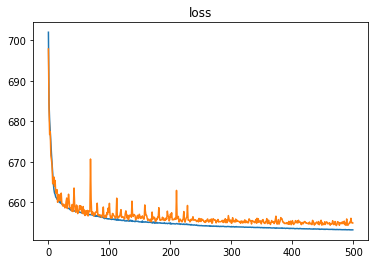

In [ ]:
plt.plot(logs['loss'])
plt.plot(logs['val_loss'])
plt.title('loss')

[0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
[-1.64485363 -1.03643339 -0.67448975 -0.38532047 -0.12566135  0.12566135
  0.38532047  0.67448975  1.03643339  1.64485363]


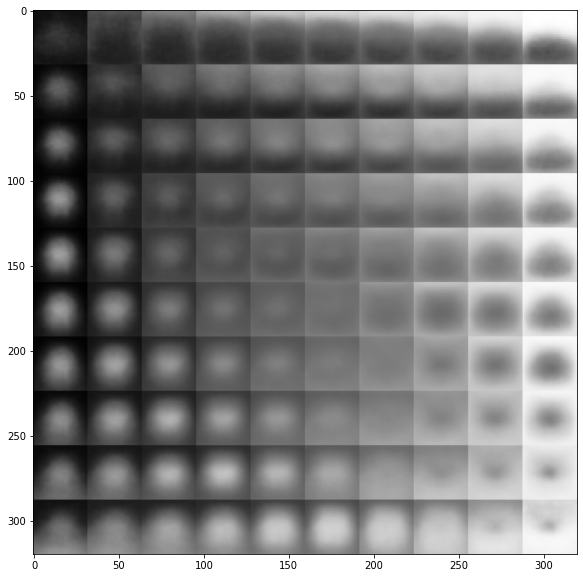

In [ ]:
# display a 2D manifold of the digits
n = 10  # figure with 15x15 digits
digit_size = 32
figure = np.zeros((digit_size * n, digit_size * n))#1920*1920

#np.linspace產生一個(star,end,number)的list
print(np.linspace(0.05, 0.95, n))
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))
print(grid_x)

#enumerate函数用于将一个可遍历的数据对象(i:順序,xi:內容)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()

0


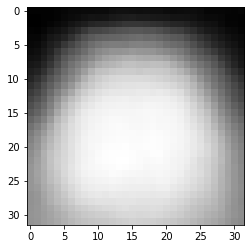

1


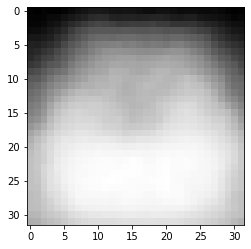

2


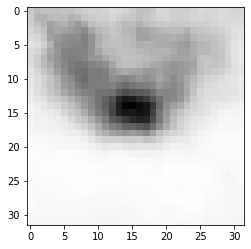

3


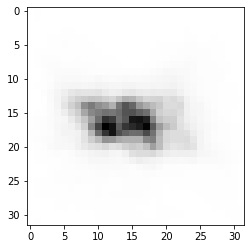

4


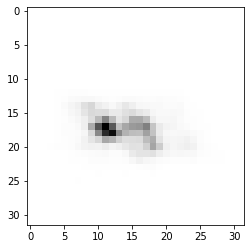

5


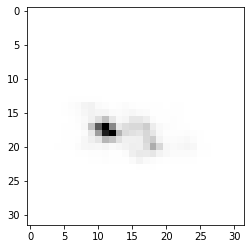

6


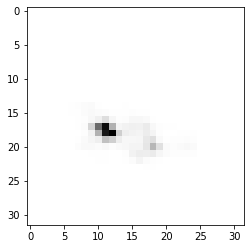

7


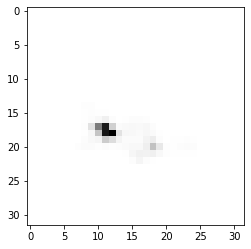

8


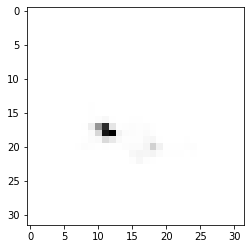

9


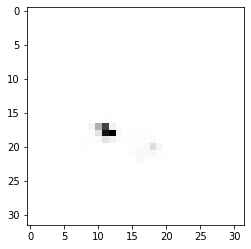

In [ ]:
for x in range(0,10):
  print(x)
  z_sample = np.array([[x, 2]])
  #print(z_sample)
  x_decoded = decoder.predict(z_sample)
  #print(x_decoded.shape)
  digit = x_decoded[0]
  #print(digit.shape)
  digit=digit.reshape(32,32)
  plt.imshow(digit, cmap='Greys_r')
  plt.show()

In [ ]:
#x_test輸入，batch_size=batch_size
picture=x_test[0:10]

'''
picture=picture.reshape((1,784))
print(picture.shape)
x_test_encoded = encoder.predict(picture)

print(x_test_encoded)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_tesy, cmap='viridis')
plt.colorbar()
plt.show()
'''

"\npicture=picture.reshape((1,784))\nprint(picture.shape)\nx_test_encoded = encoder.predict(picture)\n\nprint(x_test_encoded)\nplt.figure(figsize=(6, 6))\nplt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_tesy, cmap='viridis')\nplt.colorbar()\nplt.show()\n"